In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
%matplotlib inline

In [3]:
path='/content/drive/MyDrive/'
os.chdir(path)
retval = os.getcwd()
print ("Current working directory %s" % retval)

Current working directory /content/drive/MyDrive


### <font color='green'> Read and explore the data </font>

Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using   hashtag   based   supervision   but   such   datasets   are   noisy   in   terms   of   labels   and language.  Furthermore,  many  tweets  are  replies  to  other  tweets  and  detecting  sarcasm  in these  requires  the  availability  of  contextual  tweets.In  this  hands-on  project,  the  goal  is  to build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs

To overcome the limitations related to noise in Twitter datasets, this News Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). We collect real (and non-sarcastic) news headlines from HuffPost.

**This new dataset has following advantages over the existing Twitter datasets:**

· Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.

· Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.

· Unlike tweets which are replies to other tweets, the news headlines we obtained are self-contained. This would help us in teasing apart the real sarcastic elements.

In [4]:
data = pd.DataFrame([json.loads(line) for line in open('Sarcasm_Headlines_Dataset.json', 'r')])
data.head(10)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...


The dataset has three columns:

1. "Headline" with the actual text, that needs to analyzed.

2. "Article Link" with the source URL. This can be discarded during the model building process.

3. "is_sarcastic" with the classification details, where 1 means Sarcastic and 0 means non sarcastic

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


### <font color='green'> Checking Data Balance between the classes </font>

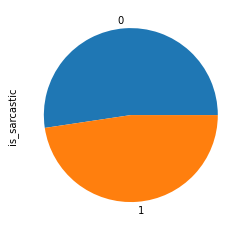

In [6]:
data['is_sarcastic'].value_counts().plot(kind='pie')

### <font color='green'> Retain relevant columns - Drop column "article_link" </font>

In [7]:
data.drop(['article_link'],inplace=True,axis=1)

In [8]:
data.head(10)

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...
5,0,my white inheritance
6,0,5 ways to file your taxes with less stress
7,1,richard branson's global-warming donation near...
8,1,shadow government getting too large to meet in...
9,0,lots of parents know this scenario


### <font color='green'> Get length of each sentence - Average length of News headlines</font>

In [9]:
from statistics import mean
Average_len = [len(data['headline'][i]) for i in range(0,len(data))]
print("Average length of News headlines:",mean(Average_len))

Average length of News headlines: 62.30857122890387


In [10]:
data['headline'][100]

'report: 70% of trump endorsements made after staring at bedroom ceiling for 4 hours'

### <font color='green'> Create features and labels</font>

In [11]:
from sklearn.model_selection import train_test_split
X=data['headline'].values
y=data['is_sarcastic'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,shuffle = True)

### <font color='green'> Get indices for words </font>

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size=10000
embedding_dim=50
max_length=32
oov_tok='<oov>'

tokenizer= Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index=tokenizer.word_index
X_train_sequences=tokenizer.texts_to_sequences(X_train)
X_train_padded=pad_sequences(X_train_sequences, maxlen=max_length, padding='pre', truncating='post')
X_test_sequences=tokenizer.texts_to_sequences(X_test)
X_test_padded=pad_sequences(X_test_sequences, maxlen=max_length, padding='pre', truncating='post')

### <font color='green'> Get vocabulary size </font>

In [50]:
dict_items = tokenizer.word_counts.items()
print(list(dict_items)[:10])

[('how', 676), ('trump', 1118), ('really', 202), ('feels', 50), ('about', 903), ('queer', 42), ('people', 314), ('explained', 6), ('in', 3616), ('one', 449)]


In [51]:
dict_items = tokenizer.word_index.items()
print(list(dict_items)[:10])

[('<oov>', 1), ('to', 2), ('of', 3), ('the', 4), ('in', 5), ('for', 6), ('a', 7), ('on', 8), ('and', 9), ('with', 10)]


In [28]:
print(tokenizer.document_count)

22895


In [52]:
dict_items = tokenizer.word_docs.items()
print(list(dict_items)[:10])

[('trump', 1110), ('really', 200), ('feels', 50), ('people', 312), ('about', 889), ('one', 443), ('how', 672), ('explained', 6), ('sentence', 18), ('in', 3508)]


### <font color='green'> Print shapes of Features and Labels after padding </font>

In [13]:
X_train_padded.shape,X_test_padded.shape

((22895, 32), (5724, 32))

In [14]:
X_train_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   27,
         13,  109,  638,   17,  781,   67, 4774,    5,   43, 1939],
      dtype=int32)

### <font color='green'> Create a weight matrix using GloVe embeddings </font>

In [15]:
import gensim.downloader as api
glove_model = api.load('glove-wiki-gigaword-50')
embedding_vector_length = glove_model.vector_size

[==================================================] 100.0% 66.0/66.0MB downloaded


In [16]:
embedding_matrix = np.zeros((vocab_size + 1, embedding_vector_length))

for word, i in sorted(word_index.items(),key=lambda x:x[1]):
    if i > (vocab_size+1):
        break
    try:
        embedding_vector = glove_model[word] #Reading word's embedding from Glove model for a given word
        embedding_matrix[i] = embedding_vector
    except:
        pass

In [40]:
embedding_matrix.shape

(10001, 50)

### <font color='green'> Define and compile a traditional LSTM model </font>

**Please note , I have build a bidirection LSTM model below.**

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten,LSTM
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_dim,weights=[embedding_matrix], trainable=False,input_length=max_length))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Flatten())
model.add(Dense(units=100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=60,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1,activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 32, 50)            500050    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               91648     
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               12900     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                6060      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)               

In [20]:
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
history=model.fit(X_train_padded,y_train,epochs=20,validation_data=(X_test_padded,y_test))

Epoch 1/20
716/716 [==============================] - 55s 72ms/step - loss: 0.6106 - accuracy: 0.6651 - val_loss: 0.5014 - val_accuracy: 0.7500
Epoch 2/20
716/716 [==============================] - 51s 71ms/step - loss: 0.4932 - accuracy: 0.7677 - val_loss: 0.4259 - val_accuracy: 0.7918
Epoch 3/20
716/716 [==============================] - 51s 71ms/step - loss: 0.4319 - accuracy: 0.8048 - val_loss: 0.3950 - val_accuracy: 0.8174
Epoch 4/20
716/716 [==============================] - 51s 72ms/step - loss: 0.3953 - accuracy: 0.8228 - val_loss: 0.3934 - val_accuracy: 0.8220
Epoch 5/20
716/716 [==============================] - 51s 71ms/step - loss: 0.3727 - accuracy: 0.8326 - val_loss: 0.3628 - val_accuracy: 0.8361
Epoch 6/20
716/716 [==============================] - 51s 71ms/step - loss: 0.3583 - accuracy: 0.8425 - val_loss: 0.3508 - val_accuracy: 0.8367
Epoch 7/20
716/716 [==============================] - 51s 71ms/step - loss: 0.3345 - accuracy: 0.8522 - val_loss: 0.3410 - val_accuracy:

### <font color='green'> Plot Accuracy and Loss </font>

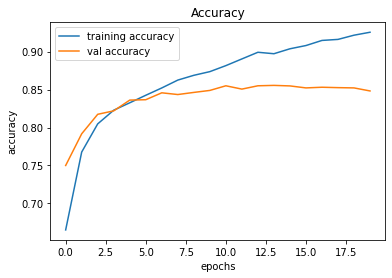

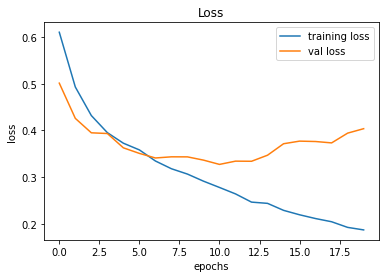

In [21]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### <font color='green'> Define and compile a Bidirectional LSTM model </font>

**Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems. In problems where all timesteps of the input sequence are available, Bidirectional LSTMs train two instead of one LSTMs on the input sequence.**

In [22]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [23]:
inp = Input(shape=(max_length,))
x = Embedding(vocab_size+1, embedding_dim, weights=[embedding_matrix],trainable=False)(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(1, activation="sigmoid")(x)
model_bi = Model(inputs=inp, outputs=x)
model_bi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bi.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 32, 50)            500050    
_________________________________________________________________
bidirectional (Bidirectional (None, 32, 200)           120800    
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101   

In [24]:
history_bi=model_bi.fit(X_train_padded,y_train,epochs=20,validation_data=(X_test_padded,y_test))

Epoch 1/20
716/716 [==============================] - 112s 113ms/step - loss: 0.6042 - accuracy: 0.6564 - val_loss: 0.4228 - val_accuracy: 0.8040
Epoch 2/20
716/716 [==============================] - 79s 110ms/step - loss: 0.4268 - accuracy: 0.8038 - val_loss: 0.3763 - val_accuracy: 0.8276
Epoch 3/20
716/716 [==============================] - 79s 110ms/step - loss: 0.3790 - accuracy: 0.8292 - val_loss: 0.3509 - val_accuracy: 0.8447
Epoch 4/20
716/716 [==============================] - 79s 110ms/step - loss: 0.3460 - accuracy: 0.8479 - val_loss: 0.3485 - val_accuracy: 0.8417
Epoch 5/20
716/716 [==============================] - 79s 110ms/step - loss: 0.3225 - accuracy: 0.8567 - val_loss: 0.3387 - val_accuracy: 0.8489
Epoch 6/20
716/716 [==============================] - 79s 110ms/step - loss: 0.3054 - accuracy: 0.8677 - val_loss: 0.3331 - val_accuracy: 0.8541
Epoch 7/20
716/716 [==============================] - 79s 110ms/step - loss: 0.2862 - accuracy: 0.8787 - val_loss: 0.3515 - val_a

### <font color='green'> Plot Accuracy and Loss for the Bidirectional LSTM Model </font>

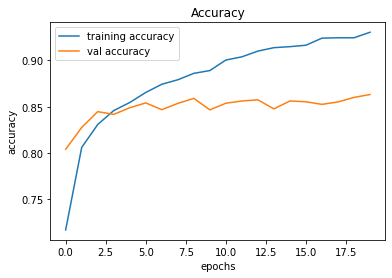

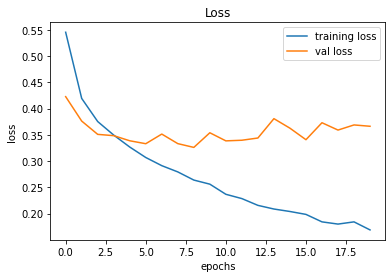

In [37]:
plt.figure(0)
plt.plot(history_bi.history['accuracy'], label='training accuracy')
plt.plot(history_bi.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history_bi.history['loss'], label='training loss')
plt.plot(history_bi.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### <font color='green'> Confusion Matrix for Bidirectional LSTM </font>

In [63]:
from sklearn.metrics import confusion_matrix
y_pred_=model_bi.predict(X_test_padded)
y_pred=[]

for prob in y_pred_:
    if prob > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
confusion_matrix(y_test,y_pred)

array([[2589,  406],
       [ 377, 2352]])

### <font color='green'> Confusion Matrix for Unidirectional LSTM </font>

In [64]:
from sklearn.metrics import confusion_matrix
y_pred_=model.predict(X_test_padded)
y_pred=[]

for prob in y_pred_:
    if prob > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
confusion_matrix(y_test,y_pred)

array([[2678,  317],
       [ 552, 2177]])

### <font color='green'> Conclusion </font>

1. Since bidirectional LSTM runs the inputs in two ways, one from past to future and one from future to past, hence the Bi-LSTM using the two hidden states combined is able in any point in time to preserve information from both past and future. This can significantly improve erformance. 

2. In the above two models with Traditional LSTM and Bi-LSTM, I see slight improvements in both Training and Validation Accuracies. 
